# Instantaneous analysis of interfaces

---



Copy this script into each of the directories corresponding to the different types of regim we expect to see:
- Gas-liquid
- Border-liquid
- Liquid-liquid


Execute to obtain profiles of the following, relative to an instantaneous interface:
- Density profile for both CO2 and H2O.
- Time averaged cos(theta) for the dipoles of CO2 and H2O.
- Heatmaps giving the frequency of occurence at cos(theta) and distance from WC for CO2. 
- Heatmaps giving the frequency of occurence at cos(theta) and distance from WC for H2O.
- Profile of the degree of hydrogen bonding against distance from interface for both species.  

In [1]:
# will need to initially set path location to whever finalised on_a_WIM module is located. 

import sys
import MDAnalysis as mda
from WillardChandler import WillardChandler
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib as mpl
from matplotlib import cm


# generate output file for storing results. 
if os.path.isdir('./outputs'):
    print('Output directory found.')
else:
    print('Not found. Creating directory.')
    os.mkdir('outputs')

# load trajectories and create the universe. 
pdb = 'ref_coords.pdb'
trj = 'test.dcd'
u = mda.Universe(pdb,trj)

/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Output directory found.


In [2]:
# -----------------------------------------------------
# perform the WC interfacial analysis
# OR load previously generated surface into script. 
# -----------------------------------------------------

WC_inter = WillardChandler(u,lower_z=15,upper_z=30)
result = WC_inter.generate(grid=100,new_inter=True)
WC_inter.save() # NOW DONT SWITCH ON


---------------------
 Loading trajectory  
---------------------

Output directory detected.

Obtaining atom coordinates.
Parsing through frames.
Total: 199.


Number of cores: 4

Generating frames ...


  0%|          | 0/199 [00:00<?, ?it/s]/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a fut

Done



/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/universe.py:449: UserWarning: Residues specified but no atom_resindex given.  All atoms will be placed in first Residue.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/universe.py:455: UserWarning: Segments specified but no segment_resindex given.  All residues will be placed in first Segment
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  warnings.warn("Found no information for attr: '{}'"
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1080: UserWa

---

# Density analysis 

Perform density measurements relative to instantaneous interface.

Water density in red; CO2 density in blue. 





---

In [3]:
# perform density measurements. 
# set the species; binds; lower bound; upper bound. 
data_Oxygen = WC_inter.Density_run('OW',150,-15,15)
data_Carbon = WC_inter.Density_run('C',150,-15,15)

# function for quick plot
#WC_inter.Density_plot(data_Oxygen,data_Carbon)


Obtaining OW density.
Calculating density profile ...


  1%|          | 1/199 [00:00<00:33,  5.98it/s]/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it 

Generating histogram(s)
Done


Obtaining C density.
Calculating density profile ...


100%|██████████| 199/199 [00:00<00:00, 1070.45it/s]


Generating histogram(s)
Done



In [4]:
# create figures directory for generated plots. 
if os.path.isdir('./outputs/figures'):
    print('Figures directory found.')
else:
    print('No figures directory found.')
    print('Create directory ...')
    os.mkdir('outputs/figures')

Figures directory found.


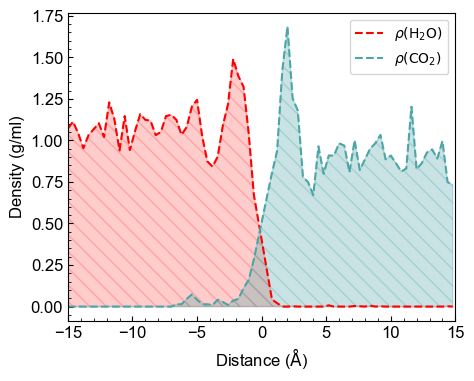

In [5]:
# load data from the generated density data files and plot.
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'


data_Oxygen = np.loadtxt('./outputs/OW_dens.dat')
ox_x = data_Oxygen[:,0]
ox_y = data_Oxygen[:,1]
data_Carbon  = np.loadtxt('./outputs/C_dens.dat')
ca_x = data_Carbon[:,0]
ca_y = data_Carbon[:,1]

smooth = 2
fig, ax = plt.subplots(figsize=(5,4)) # change the figsize to make appropriate for figure
ax.plot(ox_x[::smooth],ox_y[::smooth],'--',
        color='r',
        label = r'$\rho \mathrm{(H_2O)}$',
        linewidth=1.5)
zeros = [0]*len(ox_x[::smooth])
ax.fill_between(ox_x[::smooth],zeros,ox_y[::smooth],
                color='red',
                alpha=0.2,hatch=r'\\')

if data_Carbon is not None:
    ax.plot(ca_x[::smooth],ca_y[::smooth],'--',
            color='#4ca5a6',
            label = r'$\rho \mathrm{(CO_2)}$',
            linewidth=1.5)
    zeros = [0]*len(ca_x[::smooth])
    ax.fill_between(ca_x[::smooth],zeros,ca_y[::smooth],
                    color='#4ca5a6',
                    alpha=0.3,hatch=r'\\')
    
ax.set_xlim(-15,15)
#ax.set_ylim(0,1.5)
ax.set_xticks(np.arange(-15,16,5))
ax.set_xlabel('Distance ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Density (g/ml)',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.legend(loc='upper right')
plt.savefig('./outputs/figures/dens_plot.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:237: RuntimeWarning: divide by zero encountered in log
  nrg = [-0.000239006*R*T*np.log(i/const) for i in dens]


[3.2893101878707154, 2.8760803650713984, 2.8760803650713984, 2.63435641455415, 2.8760803650713984, 2.221126591754833, 2.1292274108940616, 2.4628505422720814, 1.8078967689555152, 1.916590429868338, 2.1292274108940616, 2.1292274108940616, 2.221126591754833, 1.916590429868338, 3.2893101878707154, 2.4628505422720814, 2.63435641455415, 2.4628505422720814, 2.4628505422720814, 3.2893101878707154, 1.916590429868338, 2.221126591754833, 2.8760803650713984, 3.2893101878707154, 2.4628505422720814, 2.329820252667655, 2.63435641455415, 2.63435641455415, 1.6748664793510888, 2.221126591754833, 2.221126591754833, 2.1292274108940616, 1.6002486422820446, 1.8078967689555152, 1.4465400503155532, 1.3946669461561982, 1.4465400503155532, 0.7737889966834102, 0.8895379424961094, 0.6000953618870621, 0.430229558359025, 0.27117016353642764, 0.2453261645952436, 0.14573443034409017, 0.16436609094436339, 0.04731972434516596, 0.06842510059467477, 0.021947188153820463, 0.0, 0.021947188153820463, 0.16122009622370115, 0.

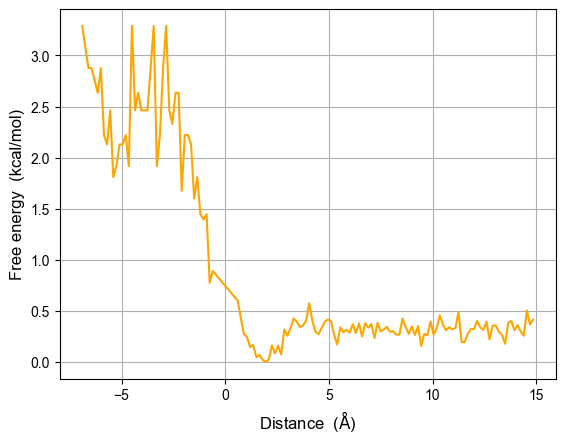

In [6]:
import math as m

result = WC_inter.nrg_from_dens()
data = np.loadtxt('./outputs/free_energy.dat')
dist = data[:,0]
nrg = data[:,1]

updated_dist = []
updated_nrg = []
for i in range(len(nrg)):
    if m.isinf(nrg[i])==False:
        updated_dist.append(dist[i])
        updated_nrg.append(nrg[i])
print(updated_nrg)


fig,ax=plt.subplots()
ax.plot(updated_dist,updated_nrg,color='orange')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Free energy  (kcal/mol)',size=12)

ax.grid()
plt.savefig('./outputs/figures/co2_free_energy.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

---

## Orientational analysis

Two sets of plots here. The first giving <cos(theta)>; the second gives heatmap of cos(theta) with distance from the interface.
Bins only counted for <cos(theta)> if hits greater than 0.1*max(hits) for the whole profile, helps to eliminate unecessary noise. 

---

In [7]:
# orientational analysis|
#ori_water = WC_inter.Orientation_run('water','time',75,-10,10)
ori_carbon = WC_inter.Orientation_run('carbon','time',75,-10,10,'WC','bond')

# orientational plot
#WC_inter.Orientation_plot(ori_water,ori_carbon)


Obtaining orientations.
Calculating orientation profile ...


100%|██████████| 199/199 [00:00<00:00, 246.35it/s]


Generating histogram(s)
Done.



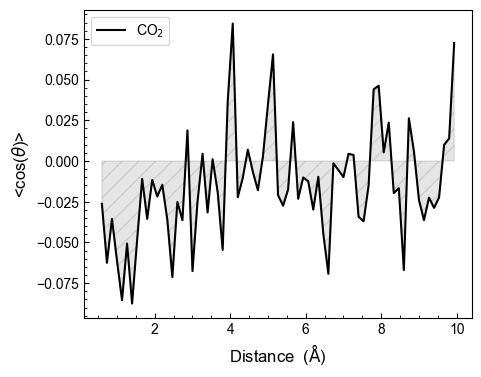

In [8]:
# load the data
# h2o_ori = np.loadtxt('./outputs/orientation_water.dat')
# h2o_x   = h2o_ori[:,0]
# h2o_y   = h2o_ori[:,1]

co2_ori = np.loadtxt('./outputs/orientation_carbon.dat')
co2_x   = co2_ori[:,0]
co2_y   = co2_ori[:,1]

# plot of the time-averaged profiles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax=plt.subplots(figsize=(5,4))
# h2o
# ax.plot(h2o_x,h2o_y,'-',color='red',label='H$_2$O')
# zeros = [0]*len(h2o_x)
# ax.fill_between(h2o_x,zeros,h2o_y,color='red',alpha=0.1,hatch=r"//")

# co2
ax.plot(co2_x,co2_y,'-',color='black',label='CO$_2$')
zeros = [0]*len(co2_x)
ax.fill_between(co2_x,zeros,co2_y,color='black',alpha=0.1,hatch=r"//")

#ax.set_xlim(-10,10)
#ax.set_ylim(-0.3,0.1)


ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel(r'<cos($\theta$)>',size=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both',which='both',direction='in')

ax.legend()
plt.savefig(f'./outputs/figures/ori_profile_gas.png',dpi=800,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

The above analysis was performed using time-averaged results. The heat maps below show the distribution as a function of both cos(theta) and distance from interface.

In [8]:
# orientational analysis
ori_water = WC_inter.Orientation_run('water','heatmap',200,-10,10)
ori_carbon = WC_inter.Orientation_run('carbon','heatmap',200,-10,10)


Obtaining orientations.
Calculating orientation profile ...


100%|██████████| 20001/20001 [03:53<00:00, 85.83it/s]


Generating histogram(s)

Obtaining orientations.
Calculating orientation profile ...


100%|██████████| 20001/20001 [02:27<00:00, 135.92it/s]


Generating histogram(s)


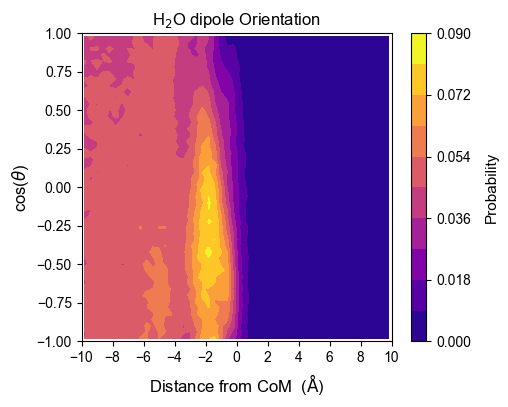

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm

# plot of the water heatmap
fig,ax = plt.subplots(figsize=(5,4))
X = ori_water[0]
Y = ori_water[1]
H = ori_water[2]

max_val = max(H.flatten())
levels = np.linspace(0,round(max_val,2),10+1)
cs = ax.contourf(X,Y,H,
                  vmin=0,vmax=max_val,
                  levels=levels,
                  cmap=cm.plasma)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Probability',size=11,labelpad=10)
ax.set_xlabel('Distance from CoM  ($\mathrm{\AA}$)',size=12,labelpad=5)
ax.set_ylabel(r'cos($\theta$)',size=12)


ax.set_xlim(-10,10)
ax.set_ylim(-1,1)
ax.set_xticks(np.arange(-10,11,2))

# fig.colorbar(plot)
plt.title('H$_2$O dipole Orientation')
plt.savefig(f'./outputs/figures/heatmap_ori_water.png',dpi=800,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

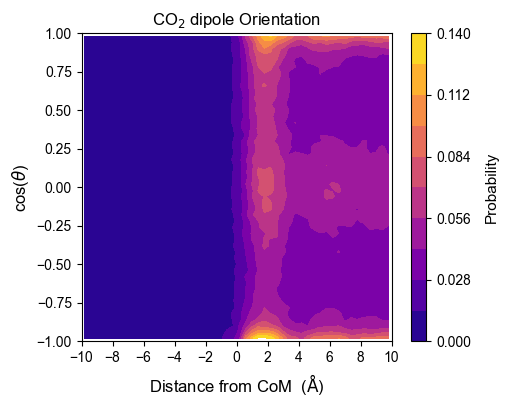

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm

# plot of the water heatmap
fig,ax = plt.subplots(figsize=(5,4))
X = ori_carbon[0]
Y = ori_carbon[1]
H = ori_carbon[2]

max_val = max(H.flatten())
levels = np.linspace(0,round(max_val,2),10+1)
cs = ax.contourf(X,Y,H,
                  vmin=0,vmax=max_val,
                  levels=levels,
                  cmap=cm.plasma)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Probability',size=11,labelpad=10)
ax.set_xlabel('Distance from CoM  ($\mathrm{\AA}$)',size=12,labelpad=5)
ax.set_ylabel(r'cos($\theta$)',size=12)


ax.set_xlim(-10,10)
ax.set_ylim(-1,1)
ax.set_xticks(np.arange(-10,11,2))

# fig.colorbar(plot)
plt.title('CO$_2$ dipole Orientation')
plt.savefig(f'./outputs/figures/heatmap_ori_carbon.png',dpi=800,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

---

## Hydrogen bonding analysis

Compute the H bonding profile as a function of the distance from the instantaneous interface.

CS suggests implementing change, whereby at each frame I count the number of frames associated with a particular oxygen atom. 
E.g., frame 1: record the number of hits of atom ith ID XXX. Calculate the position of this atom relative to the interface, and place this number of hits there. Possibility that this may be impacted by the wrapping of our coordinates - possible that this may negated by use of the MDAnalysis module, which I believe accounts for wrapping. 

---

In [11]:
result = WC_inter.Hbonds_run(bins=100,lower=-10,upper=10)


Obtaining Hbonds.
0.0


100%|██████████| 7786883/7786883 [16:31<00:00, 7850.07it/s]  


Running proximity calculations.


100%|██████████| 20001/20001 [07:28<00:00, 44.60it/s]


Acquiring background density.


100%|██████████| 20001/20001 [05:10<00:00, 64.46it/s]


Binning.


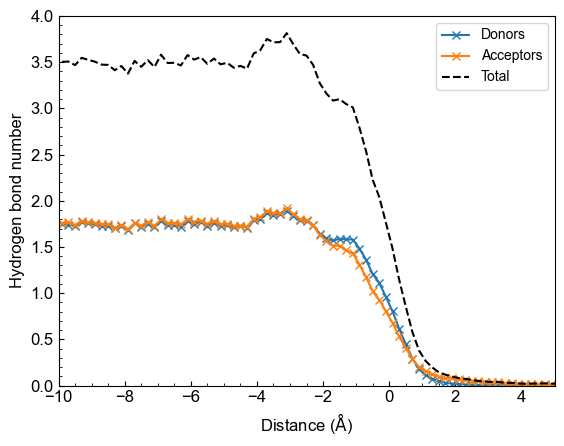

In [14]:
donor_dat = np.loadtxt('./outputs/donor.dat')
don_x = donor_dat[:,0]
don_y = donor_dat[:,1]
accept_dat = np.loadtxt('./outputs/acceptor.dat')
acc_x = accept_dat[:,0]
acc_y = accept_dat[:,1]

tot_x = acc_x
tot_y = [don_y[i]+acc_y[i] for i in range(len(don_y))]


fig,ax=plt.subplots()
ax.plot(don_x,don_y,'-x',label='Donors')
ax.plot(acc_x,acc_y,'-x',label='Acceptors')
ax.plot(tot_x,tot_y,'--',color='black',label='Total')

ax.set_xlim(-10,5)
ax.set_ylim(0,4)
#ax.set_xticks(np.arange(-10,11,2.5))
ax.set_xlabel('Distance ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Hydrogen bond number',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()

plt.savefig('./outputs/figures/hbond_profile.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

## Cluster analysis

Compute the RDFs of the first level of molecules for each type of molecule. 

### Dipole orientation

In [5]:
result_dipole = WC_inter.Cluster_orientations('water_dipole')

100%|██████████| 199/199 [00:03<00:00, 57.74it/s]


[nan, 0.020024672270401375, 0.012521598822144112, 0.011696445666883954, 0.012546356190142901, 0.010051975377393559, 0.008391847363418659, 0.01153352544460766, 0.014542985402340993, 0.01070895515222679, 0.012212729417868813, 0.013462262004508414, 0.011533280038207772, 0.014649854834966046, 0.00738634039706372, 0.009005554121334861, 0.010118602043763964, 0.009267273794071383, 0.014673355322047386, 0.0111903354749182, 0.010165968713204843, 0.01462392980128375, 0.015541609856407552, 0.012126841983928102, 0.01194493696801126, 0.012898132939843274, 0.008628494185394348, 0.01006235233852382, 0.013877545593697714, 0.016119685967518862, 0.01516075451221552, 0.01140741620347715, 0.012850552336988943, 0.016259262983217906, 0.014355480121926506, 0.015883473501760014, 0.01720495240067976, 0.013021795407318572, 0.015390286023685364, 0.016044289828642182, 0.016699324566478782, 0.018831183900781142, 0.01737123600365688, 0.017724082599010788, 0.01985029820041033, 0.017353633787919064, 0.017117712496053

/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:487: RuntimeWarning: invalid value encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


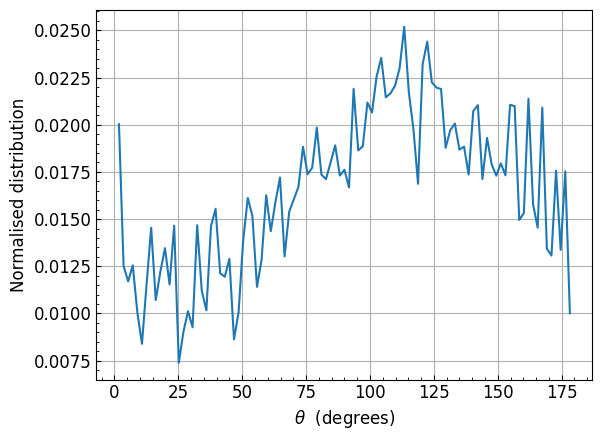

In [6]:
# plot 

fig,ax=plt.subplots()
ax.plot(result_dipole[1],result_dipole[0],'-',label='Angular')

ax.set_xlabel(r'$\theta$  (degrees)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.legend()
ax.grid()
plt.savefig('./outputs/figures/cluster_angles.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()


### Dipole-Carbon metrics

In [7]:
result_dist = WC_inter.Cluster_distances('dip_C')
result_ori = WC_inter.Cluster_orientations('dip_C')

100%|██████████| 199/199 [00:00<00:00, 625.39it/s]

[inf, 0.020024673331172194, 0.010017278261264266, 0.013367368365748011, 0.012546355191296864, 0.003015592293674411, 0.010070215593288852, 0.007208456243512681, 0.010116853240540553, 0.005072664884423035, 0.010177278828583762, 0.014390685249792303, 0.009824649957492092, 0.007918835538508303, 0.00923292914848621, 0.009005557938387893, 0.009792189537697053, 0.008031632091401664, 0.007923614899859387, 0.00755347949915184, 0.011236075445485494, 0.010518971689142832, 0.013568049530092104, 0.010937940212766692, 0.009877548077828181, 0.012230993316780783, 0.011432759784442212, 0.01048159949466875, 0.014081632804879713, 0.008756376245324483, 0.012245229988532988, 0.011407421141802905, 0.01266429119078045, 0.016076581196030983, 0.015432147559097916, 0.013059722737496606, 0.01320787550531266, 0.010965703983158138, 0.015052076099906064, 0.014038730067710342, 0.01736065452163182, 0.017357482947529555, 0.015098338508378242, 0.015468329514143054, 0.016168360802434622, 0.017990433884281305, 0.01632526


/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:487: RuntimeWarning: divide by zero encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


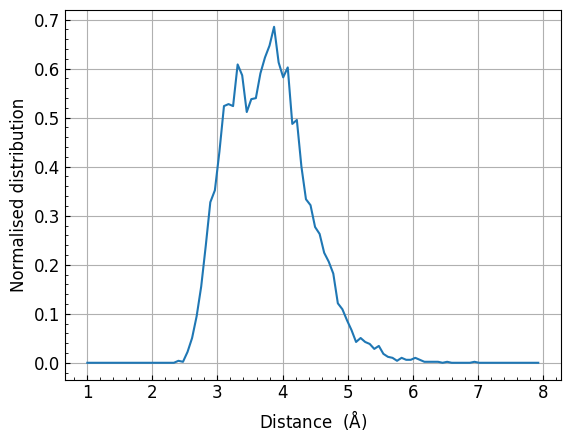

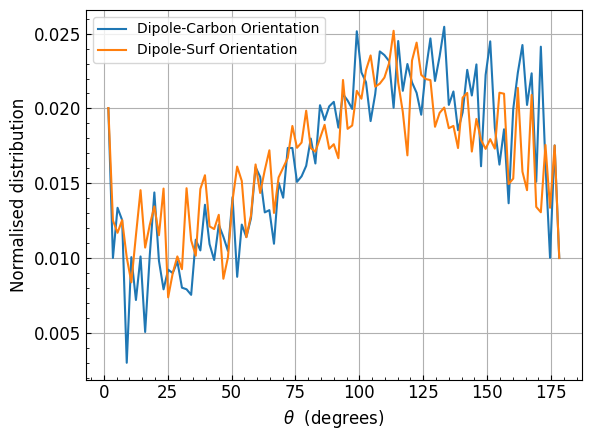

In [8]:
# plot 

fig,ax=plt.subplots()
ax.plot(result_dist[1],result_dist[0],'-')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.legend()
ax.grid()
plt.savefig('./outputs/figures/dip_C_dist.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()



fig,ax=plt.subplots()
ax.plot(result_ori[1],result_ori[0],'-',label='Dipole-Carbon Orientation')
ax.plot(result_dipole[1],result_dipole[0],'-',label='Dipole-Surf Orientation')

ax.set_xlabel(r'$\theta$  (degrees)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
ax.grid()
plt.savefig('./outputs/figures/dip_C_ang.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()


### OW-OC metrics

In [9]:
result_OW_OC_dist = WC_inter.Cluster_distances('OW_OC')

100%|██████████| 199/199 [00:00<00:00, 465.20it/s]


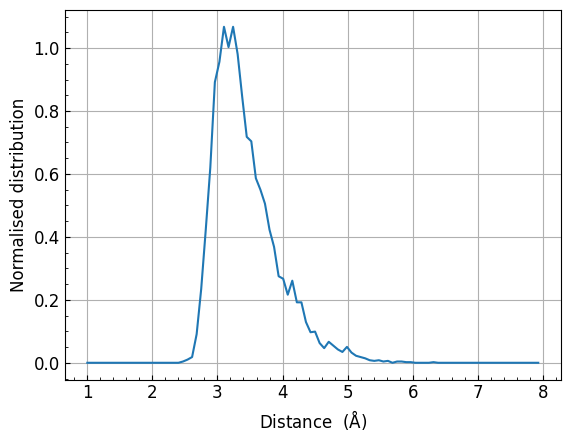

In [10]:
# plot 

fig,ax=plt.subplots()
ax.plot(result_OW_OC_dist[1],result_OW_OC_dist[0],'-')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.legend()
ax.grid()
plt.savefig('./outputs/figures/OW_OC_dist.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [5]:
min_cutoff = 0 
max_cutoff = 4
result_layer_1 = WC_inter.surf_co2(min_cutoff=min_cutoff,max_cutoff=max_cutoff)
min_cutoff = 4 
max_cutoff = 8
result_layer_2 = WC_inter.surf_co2(min_cutoff=min_cutoff,max_cutoff=max_cutoff)
min_cutoff = 8 
max_cutoff = 12
result_layer_3 = WC_inter.surf_co2(min_cutoff=min_cutoff,max_cutoff=max_cutoff)

100%|██████████| 199/199 [00:00<00:00, 1032.22it/s]


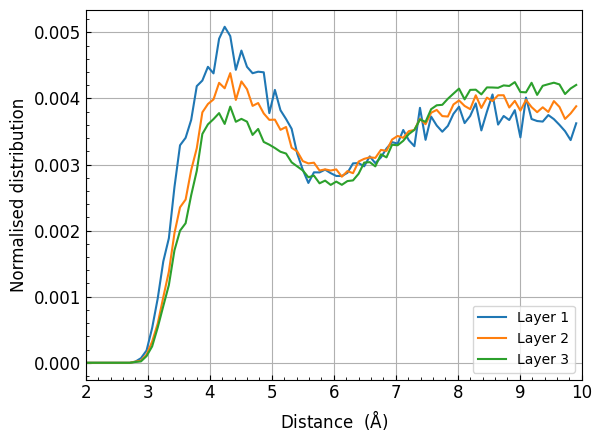

In [8]:
# plot 

fig,ax=plt.subplots()
ax.plot(result_layer_1[1],result_layer_1[0],'-',label='Layer 1')
ax.plot(result_layer_2[1],result_layer_2[0],'-',label='Layer 2')
ax.plot(result_layer_3[1],result_layer_3[0],'-',label='Layer 3')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
ax.set_xlim(2,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.grid()
ax.legend(loc='lower right')
plt.savefig('./outputs/figures/OW_OC_dist.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [13]:
result_OW_OC = WC_inter.Cluster_orientations(property='OW_OC')

100%|██████████| 199/199 [00:03<00:00, 54.77it/s]


[inf, 0.06508018487880447, 0.0901555115194376, 0.08354604047774253, 0.07276886590282884, 0.0683534325662762, 0.06881314838003301, 0.06848030732735798, 0.055010423043637666, 0.049035742012827926, 0.04834205394573072, 0.05152796836208393, 0.060656509830574204, 0.06295478158809734, 0.049488480660326926, 0.05611152952524029, 0.04994019718373827, 0.04849873285564023, 0.04783513834987448, 0.0528743351189885, 0.04788706314904387, 0.04618083095142237, 0.04243106183019205, 0.0442273060590319, 0.04295583101957895, 0.044031557277396015, 0.038181086770369986, 0.03773382126946432, 0.03469386398424428, 0.03482648202859013, 0.031098983614801064, 0.02984940573243187, 0.029984622119640866, 0.022836043515755487, 0.02548097721641955, 0.02206037986355558, 0.02467781051410632, 0.021760105483282353, 0.016743278201591768, 0.01654567388578725, 0.014219226858585893, 0.013263703443158888, 0.014773668003110056, 0.013373625961071776, 0.012006228750248184, 0.011462950758992408, 0.01299678170996664, 0.0066338378483

/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:487: RuntimeWarning: divide by zero encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


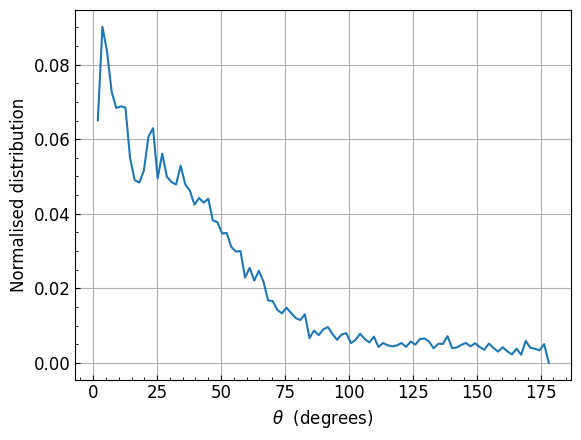

In [14]:
fig,ax=plt.subplots()
ax.plot(result_OW_OC[1],result_OW_OC[0],'-')

ax.set_xlabel(r'$\theta$  (degrees)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid()
plt.savefig('./outputs/figures/dip_C_ang.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [3]:
result = WC_inter.Hbond_prop()
hist_dist_x = result[0][1]
hist_dist_y = result[0][0]

hist_ang_x  = result[1][1]
hist_ang_y  = result[1][0]


100%|██████████| 199/199 [00:00<00:00, 245.35it/s]


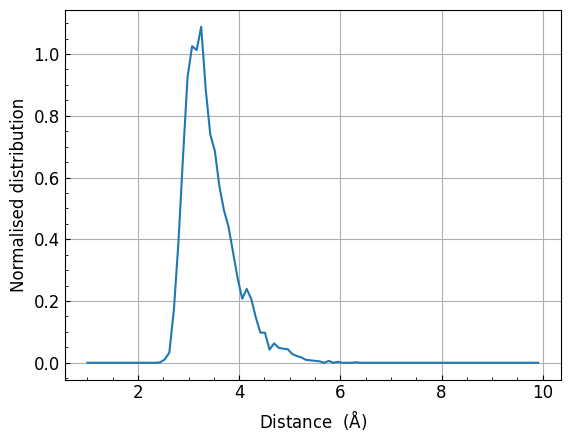

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


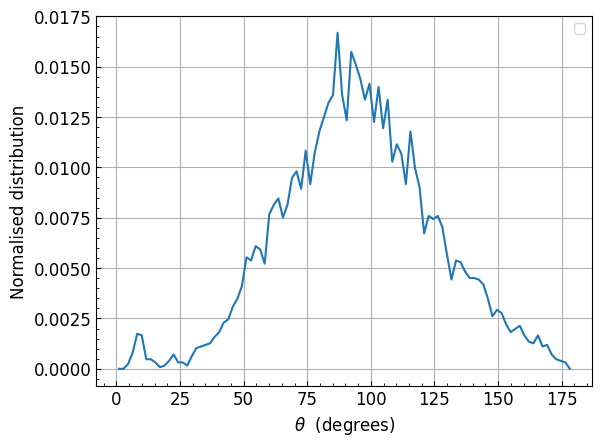

In [4]:
# plot 

fig,ax=plt.subplots()
ax.plot(hist_dist_x,hist_dist_y,'-')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.legend()
ax.grid()
plt.savefig('./outputs/figures/dip_C_dist.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()



fig,ax=plt.subplots()
ax.plot(hist_ang_x,hist_ang_y,'-')
ax.set_xlabel(r'$\theta$  (degrees)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
ax.grid()
plt.savefig('./outputs/figures/dip_C_ang.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [17]:
result = WC_inter.surface_rdf(100)

100%|██████████| 199/199 [00:00<00:00, 3485.78it/s]


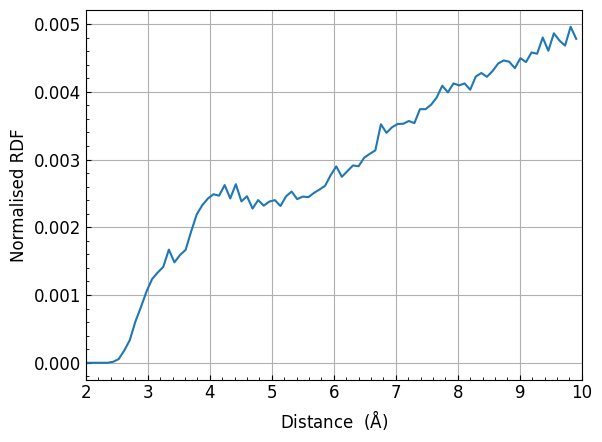

In [18]:
# plot 
fig,ax=plt.subplots()
ax.plot(result[1],result[0],'-')

ax.set_xlabel('Distance  ($\mathrm{\AA}$)',size=12)
ax.set_ylabel('Normalised RDF',size=12)
ax.set_xlim(2,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.grid()
plt.savefig('./outputs/figures/OW_OC_dist.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [19]:
result = WC_inter.Cluster_orientations('OH_bonds')

100%|██████████| 199/199 [00:03<00:00, 59.50it/s]


[inf, 0.005006168067600344, 0.0112694389399297, 0.005848222833441977, 0.007527813714085741, 0.011559771684002592, 0.007552662627076792, 0.010812680104319681, 0.008536100127461017, 0.01127258437076504, 0.009413978926273877, 0.010212750486178798, 0.010678962998340528, 0.010294492586732897, 0.012187461655155137, 0.01143012638477117, 0.009628992267452804, 0.011275183116120182, 0.011591950704417436, 0.014407556923957185, 0.012841223637732433, 0.01423908954335523, 0.01258130321709183, 0.012364623199299242, 0.015505447025783846, 0.01523313976515973, 0.015531289533709827, 0.015827241699136425, 0.015714279569334178, 0.016915719842458068, 0.01661851936915932, 0.016921000701824437, 0.0181583891718322, 0.016441951331343945, 0.019110732912314663, 0.016942371735210685, 0.016683590206719764, 0.01730528073867337, 0.018349956412855625, 0.017297749971504853, 0.019592771892353818, 0.01809431148727231, 0.016559496003485996, 0.0220745392369498, 0.017689177025365658, 0.021333825023680315, 0.0204461565925084

/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:487: RuntimeWarning: divide by zero encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


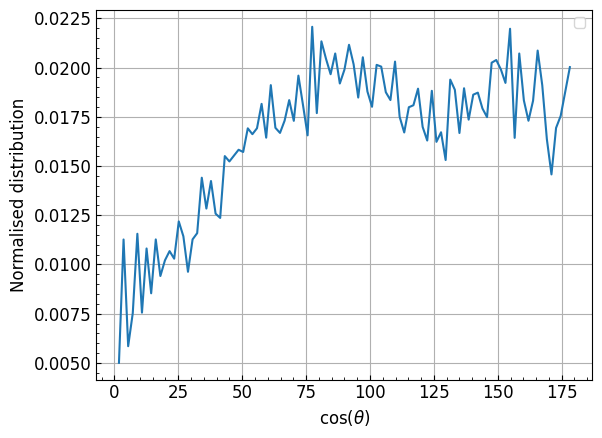

In [20]:
fig,ax=plt.subplots()
ax.plot(result[1],result[0],'-')
ax.set_xlabel(r'cos($\theta$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
#ax.set_xlim(0,10)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
ax.grid()
plt.savefig('./outputs/figures/OH_bonds_ori.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [21]:
result = WC_inter.Cluster_orientations('water_dipole')

100%|██████████| 199/199 [00:03<00:00, 64.75it/s]


[nan, 0.020024672270401375, 0.012521598822144112, 0.011696445666883954, 0.012546356190142901, 0.010051975377393559, 0.008391847363418659, 0.01153352544460766, 0.014542985402340993, 0.01070895515222679, 0.012212729417868813, 0.013462262004508414, 0.011533280038207772, 0.014649854834966046, 0.00738634039706372, 0.009005554121334861, 0.010118602043763964, 0.009267273794071383, 0.014673355322047386, 0.0111903354749182, 0.010165968713204843, 0.01462392980128375, 0.015541609856407552, 0.012126841983928102, 0.01194493696801126, 0.012898132939843274, 0.008628494185394348, 0.01006235233852382, 0.013877545593697714, 0.016119685967518862, 0.01516075451221552, 0.01140741620347715, 0.012850552336988943, 0.016259262983217906, 0.014355480121926506, 0.015883473501760014, 0.01720495240067976, 0.013021795407318572, 0.015390286023685364, 0.016044289828642182, 0.016699324566478782, 0.018831183900781142, 0.01737123600365688, 0.017724082599010788, 0.01985029820041033, 0.017353633787919064, 0.017117712496053

/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:487: RuntimeWarning: invalid value encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


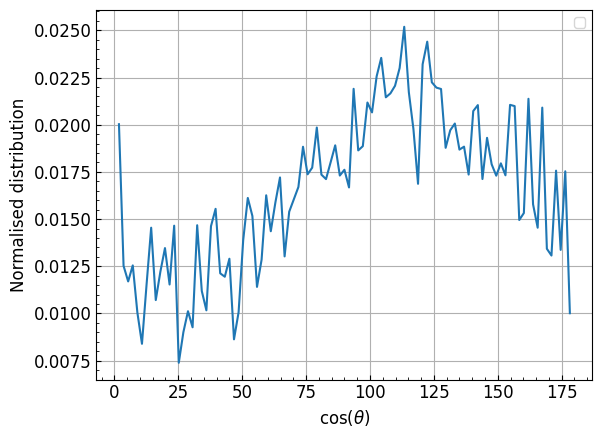

In [22]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig,ax=plt.subplots()
ax.plot(result[1],result[0],'-')
ax.set_xlabel(r'cos($\theta$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
ax.grid()
plt.savefig('./outputs/figures/water_dipole.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [3]:
result = WC_inter.save_inter_h2o()

/Users/sambrookes/opt/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1126: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [3]:
result = WC_inter.surf_co2(property='CO_angle')

  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:00<00:00, 241.31it/s]
/Users/sambrookes/Documents/Comp/project_yr3/liquid-liquid/FINAL_ANALYSIS/on_a_WIM/WillardChandler.py:550: RuntimeWarning: divide by zero encountered in double_scalars
  output = [density[i]/( 0.5*np.sin((x_range[i]*(np.pi / 180))) ) for i in range(len(x_range[:-1]))]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


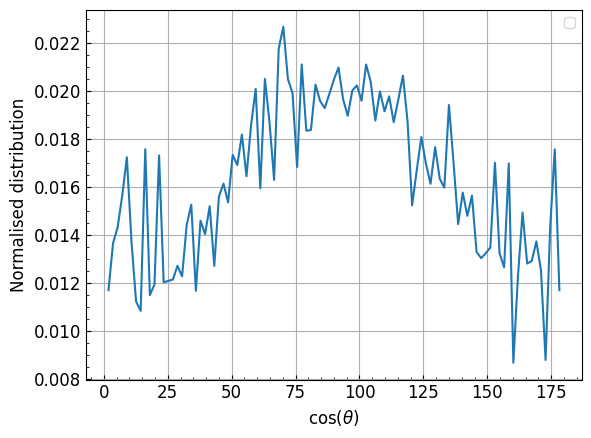

In [4]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig,ax=plt.subplots()
ax.plot(result[1],result[0],'-')
ax.set_xlabel(r'cos($\theta$)',size=12)
ax.set_ylabel('Normalised distribution',size=12)
ax.tick_params(axis="x",which='both',direction="in",labelsize=12)
ax.tick_params(axis="y",which='both',direction="in",labelsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend()
ax.grid()
plt.savefig('./outputs/figures/OC_angle.pdf',dpi=400,bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()

In [5]:
import numpy as np
inter_tot = np.zeros((6,3))
print(inter_tot[:,0])

[0. 0. 0. 0. 0. 0.]
